# *In vivo* parameter inference from single-cell fluorescence measurements.

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [105]:
import glob
import pickle
# Our numerical workhorses
import numpy as np
import scipy as sp
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath
import pandas as pd
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlIb stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/chemical_master_parameter_inference/'
tmpdir = '../../tmp/'

## Comparison of expeirmental vs. theoretical moments for unregulated promoter

In order to asses if our dynamical theory for the moments works we will compare experimentally determined moments to our theoretical predictions.

For this exercise we will use the microscopy data gathered so far.

In [106]:
# Read the tidy-data frame
# mwc_files = glob.glob('../../data/csv_microscopy/mwc_data/*csv')
files = glob.glob('../../data/csv_microscopy/*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)
df_micro[['date', 'operator', 'rbs', 'mean_intensity']].head()

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,date,operator,rbs,mean_intensity
0,20161204,O3,auto,52.562979
1,20161204,O3,auto,53.070565
2,20161204,O3,auto,52.323744
3,20161204,O3,auto,51.013142
4,20161204,O3,auto,44.325267


### Exploring the noise in gene expression

Having read the data let's compute the average noise for the different concentrations. Consider that the noise is defined as
\begin{equation}
\eta \equiv \frac{\sqrt{\left\langle p^2 \right\rangle - \left\langle p \right\rangle^2}}{\left\langle p \right\rangle},
\end{equation}

This means that since the mean protein copy number $\left\langle p \right\rangle$ is involved we need to take into account the **autofluorescence**. So to compute this quantity from the fluroescence measurements we need to compute
\begin{equation}
\eta = \frac{\sqrt{\left\langle (I  - \langle I_{\text{auto}}\rangle)^2 \right\rangle - \left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle^2}}{\left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle},
\end{equation}
where $I$ is the intensity of the objective strain and $\langle I_{\text{auto}}\rangle$ is the mean autofluorescence intensity.

Let's first compute this quantity for the $\Delta$*lacI* strains.

#### Two-state unregulated promoter

In [107]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Initialize data frame to save the noise
df_noise_delta = pd.DataFrame(columns=['date', 'IPTG_uM','operator', 'binding_energy',
                                 'rbs', 'repressors', 'mean', 'std', 'noise'])
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].mean_intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[data.rbs == 'delta']
    
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Append the require info
        strain_info = [date, inducer, data_inducer.operator.unique()[0],
                       data_inducer.binding_energy.unique()[0],
                       data_inducer.rbs.unique()[0],
                       data_inducer.repressors.unique()[0],
                      (data_inducer.mean_intensity - I_auto).mean(), 
                      (data_inducer.mean_intensity - I_auto).std(ddof=1)]
        # Compute the noise
        strain_info.append(strain_info[-1] / strain_info[-2])
        # Convert to a pandas series to attach to the dataframe
        strain_info = pd.Series(strain_info, index=['date', 'IPTG_uM', 'operator',
                                             'binding_energy',  'rbs', 
                                             'repressors', 'mean', 
                                             'std', 'noise'])
        # Append to the info to the data frame
        df_noise_delta = df_noise_delta.append(strain_info, ignore_index=True)
    
df_noise_delta.head()

,date,IPTG_uM,operator,binding_energy,rbs,repressors,mean,std,noise
0,20161118,0.0,O2,-13.9,delta,0.0,2300.650565,887.891968,0.385931
1,20161129,0.0,O2,-13.9,delta,0.0,2402.292147,1490.143379,0.620301
2,20161203,0.0,O2,-13.9,delta,0.0,4772.751592,1563.677810,0.327626
3,20161204,0.0,O3,-9.7,delta,0.0,5426.807369,2089.222114,0.384982
4,20161205,0.0,O3,-9.7,delta,0.0,3495.582203,1439.581127,0.411829


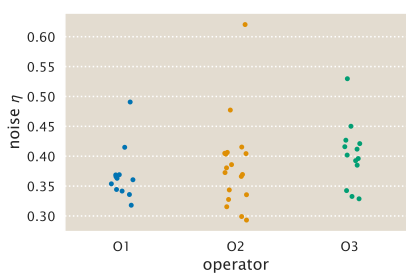

In [108]:
sns.stripplot(x=df_noise_delta['operator'], y=df_noise_delta['noise'],
              order=['O1', 'O2', 'O3'])
_ = plt.ylabel(r'noise $\eta$')
plt.tight_layout()
plt.savefig(figdir + 'noise_delta_microscopy.pdf', bbox_inches='tight')

Let's compute the expected noise from the moment dynamics considering the cell division and the multi-promoter state.

First let's define the parameters.

In [128]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double_expo.pkl',
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

# Define protein production and degradatino rates
gp = 1 / (60 * 60) # sec^-1
rp = 1000 * gp # sec^-1

Now we will define the state transition matrix $\mathbf{K}$, the mRNA production matrix $\mathbf{R}_m$, the mRNA degradation matrix $\mathbf{\Gamma}_m$, the protein production matrix $\mathbf{R}_p$, and the protein degradation matrix $\mathbf{\Gamma}_p$.

In [129]:
# Define the rate constant matrix
Km_unreg = np.array([[-kp_off, kp_on], 
                     [kp_off, -kp_on]])
# Define the mRNA production matrix
Rm_unreg = np.array([[rm, 0], 
                     [0, 0]])
# Define the mRNA degradation matrix
Gm_unreg = np.array([[gm, 0],
                     [0, gm]])

# Define the protein production matrix
Rp_unreg = np.array([[rp, 0], 
                     [0, rp]])
# Define the protein degradation matrix
Gp_unreg = np.array([[gp, 0],
                     [0, gp]])

Let's run the integration to compute the initial conditions for the simulation.

In [130]:
# Define time on which to perform integration
t = np.linspace(0, 10000, 501)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]
m2_init = [0, 0]
m3_init = [0, 0]
p1_init = [0, 0]
mp_init = [0, 0]
p2_init = [0, 0]
m2p_init = [0, 0]
mp2_init = [0, 0]
p3_init = [0, 0]

# Solve equation
mp_sol = sp.integrate.odeint(chann_cap.dpdt,
                             m0_init + m1_init + m2_init + m3_init +
                             p1_init + mp_init + p2_init + m2p_init +
                             mp2_init + p3_init,
                             t,
                             args=(Km_unreg, Rm_unreg, Gm_unreg,
                                   Rp_unreg, Gp_unreg))


mp_init = mp_sol[-1, :]

Let's now define the necesary inputs and run the numerical integration for several cell cycles.

In [131]:
# Define time for single-promoter state
t_single = 60 * 1 / 3 * 60 # sec
# Define time for two-promoter state
t_double = 60 * 2 / 3 * 60 # sec
# Define number of cell cycles
n_cycles = 10

# Integrate moment equations
df_p_unreg = chann_cap.dpdt_cycles(mp_init, t_single, t_double, n_cycles, 
                 Km_unreg, Rm_unreg, Gm_unreg,
                 Rp_unreg, Gp_unreg, n_steps=300, t_ss=10000)
df_p_unreg.head()

,time,state,cycle,m0p0P,m0p0E,m1p0P,m1p0E,m2p0P,m2p0E,m3p0P,...,m1p1P,m1p1E,m0p2P,m0p2E,m2p1P,m2p1E,m1p2P,m1p2E,m0p3P,m0p3E
0,0.000000,single,0,0.101672,0.898328,1.220488,9.240841,17.69268,118.34848,296.738226,...,12067.230518,91513.088095,9.855721e+06,8.705534e+07,176500.161687,1.183806e+06,1.208938e+08,9.182462e+08,9.897416e+10,8.741126e+11
1,4.013378,single,0,0.101672,0.898328,1.220488,9.240841,17.69268,118.34848,296.738226,...,12068.158503,91520.114270,9.857235e+06,8.706872e+07,176513.614128,1.183896e+06,1.209122e+08,9.183855e+08,9.899668e+10,8.743116e+11
2,8.026756,single,0,0.101672,0.898328,1.220488,9.240841,17.69268,118.34848,296.738226,...,12069.085454,91527.132616,9.858747e+06,8.708207e+07,176527.051581,1.183986e+06,1.209305e+08,9.185247e+08,9.901918e+10,8.745103e+11
3,12.040134,single,0,0.101672,0.898328,1.220488,9.240841,17.69268,118.34848,296.738226,...,12070.011372,91534.143142,9.860257e+06,8.709542e+07,176540.474063,1.184076e+06,1.209489e+08,9.186637e+08,9.904166e+10,8.747089e+11
4,16.053512,single,0,0.101672,0.898328,1.220488,9.240841,17.69268,118.34848,296.738226,...,12070.936258,91541.145857,9.861766e+06,8.710875e+07,176553.881588,1.184165e+06,1.209672e+08,9.188025e+08,9.906412e+10,8.749073e+11


Now let's compute the average moment for each entry consiering that cells are exponentially distributed along the cell cycle.

In [132]:
# Define index of moments to be used in the computation
moments = [(1, 0), (2, 0), (3, 0),
           (0, 1), (1, 1), (0, 2),
           (2, 1), (1, 2), (0, 3)]

# Keep only last cycle
df = df_p_unreg[df_p_unreg['cycle'] == df_p_unreg['cycle'].max()]

# Define array for integration
a_array = np.linspace(0, 1, len(df))
# Compute probability based on this array
p_a_array = np.log(2) * 2**(1 - a_array)

# Initialize list to append moments
moms = list()
# Loop through moments computing the average moment
for i, mom in enumerate(moments):
    # Generate string that finds the moment
    mom_name = 'm' + str(mom[0]) + 'p' + str(mom[1])
    # List rows with moment
    mom_bool = [x for x in df.columns if mom_name in x]
    # Extract data for this particular moment
    df_mom = df.loc[:, mom_bool].sum(axis=1)

    # Average moment and append it to list
    moms.append(sp.integrate.simps(df_mom * p_a_array,
                                   a_array))

# Define names moments
names = ['m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

# Save results into series in order to append it to data frame
df_unreg_mom = pd.Series(moms, index=names)

df_unreg_mom

m1p0    1.441194e+01
m2p0    2.811682e+02
m3p0    6.919634e+03
m0p1    8.912535e+03
m1p1    1.398629e+05
m0p2    1.003202e+08
m2p1    2.927897e+06
m1p2    1.640294e+09
m0p3    1.199382e+12
dtype: float64

In [133]:
m_noise = np.sqrt(df_unreg_mom.m2p0 - df_unreg_mom.m1p0**2) /\
          df_unreg_mom.m1p0
p_noise = np.sqrt(df_unreg_mom.m0p2 - df_unreg_mom.m0p1**2) /\
          df_unreg_mom.m0p1
print('mRNA noise = {:.2f}'.format(m_noise))
print('protein noise = {:.2f}'.format(p_noise))

mRNA noise = 0.59
protein noise = 0.51


Using a half-life of $\approx$ 40 min for the protein gives a noise level similar to what we obtained experimentally.

Let's now look at the case of the regulated promoters.

#### Three-state regulated promoter

Since we have measurements with different operators, repressor copy numbers and inducer levels, let's make sure we build a tidy data frame that contains all of this information.

In [115]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Initialize data frame to save the noise
df_noise = pd.DataFrame(columns=['date', 'IPTG_uM','operator', 'binding_energy',
                                 'rbs', 'repressors', 'mean', 'std', 'noise'])
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].mean_intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[(data.rbs != 'auto') & (data.rbs != 'delta')]
    
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Append the require info
        strain_info = [date, inducer, data_inducer.operator.unique()[0],
                       data_inducer.binding_energy.unique()[0],
                       data_inducer.rbs.unique()[0],
                       data_inducer.repressors.unique()[0],
                      (data_inducer.mean_intensity - I_auto).mean(), 
                      (data_inducer.mean_intensity - I_auto).std(ddof=1)]
        # Compute the noise
        strain_info.append(strain_info[-1] / strain_info[-2])
        # Convert to a pandas series to attach to the dataframe
        strain_info = pd.Series(strain_info, index=['date', 'IPTG_uM', 'operator',
                                             'binding_energy',  'rbs', 
                                             'repressors', 'mean', 
                                             'std', 'noise'])
        # Append to the info to the data frame
        df_noise = df_noise.append(strain_info, ignore_index=True)
    
df_noise.head()

,date,IPTG_uM,operator,binding_energy,rbs,repressors,mean,std,noise
0,20161118,0.0,O2,-13.9,RBS1027,130.0,28.660991,34.292514,1.196487
1,20161118,0.1,O2,-13.9,RBS1027,130.0,29.234495,34.792041,1.190102
2,20161118,5.0,O2,-13.9,RBS1027,130.0,71.514148,53.193801,0.743822
3,20161118,10.0,O2,-13.9,RBS1027,130.0,129.849144,87.332807,0.672571
4,20161118,25.0,O2,-13.9,RBS1027,130.0,391.288683,240.143667,0.613725


Let's now look at how the noise scales as a function of the inducer level for the different measured strains.

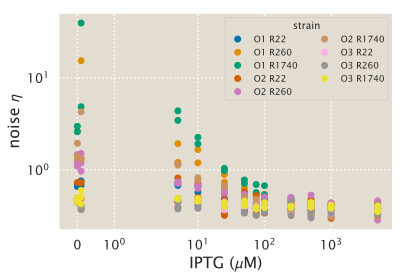

In [116]:
df_group = df_noise.groupby(['operator', 'repressors'])
    
for group, data in df_group:
    plt.plot(data.IPTG_uM, data.noise, lw=0, marker='o',
            label=group[0] + ' R{:.0f}'.format(group[1] * 2))

# Set scale for axis
plt.xscale('symlog')
plt.yscale('log')

# Label axis
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')

# Set legend
plt.legend(title='strain', ncol=2, fontsize=9)

# Set axis limit
plt.xlim(left=-5E-1)

# Save figure
plt.savefig(figdir + 'microscopy_noise_vs_iptg.png',
            bbox_inches='tight')

Let's now define the parameters for the three-state regulated promoter.

In [117]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double_expo.pkl',
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

# Define protein production and degradatino rates
gp = 1 / (30 * 60) # sec^-1
rp = 1000 * gp # sec^-1

# Number of non-specific binding sites in thermodynamic model
Nns = 4.6E6

# Cell volume
Vcell = 2.15 # fL

# MWC induction parameters
ka = 139 # µM
ki = 0.53 # µM
epsilon = 4.5 # kBT

# Define operators and energies
operators = ['O1', 'O2', 'O3']
energies = [-15.3, -13.9, -9.7]
op_dict = dict(zip(operators, energies))

# Define time for single-promoter state
t_single = 60 * 1 / 3 * 60 # sec
# Define time for two-promoter state
t_double = 60 * 2 / 3 * 60 # sec
# Define number of cell cycles
n_cycles = 4

Now we define the matrices that won't change for all parameters given these parameter values

In [118]:
# Define the production matrix
Rm_reg = np.array([[rm, 0, 0],
                   [0, 0, 0],
                   [0, 0, 0]])
# Define the degradation matrix
Gm_reg = np.array([[gm, 0, 0],
                   [0, gm, 0],
                   [0, 0, gm]])

# Define the production matrix
Rp_reg = np.array([[rp, 0, 0],
                   [0, rp, 0],
                   [0, 0, rp]])

# Define the production matrix
Gp_reg = np.array([[gp, 0, 0],
                   [0, gp, 0],
                   [0, 0, gp]])

Now let's systematically compute the moments for the different operators, repressors and inducer concentrations.

In [119]:
# Group data frame by operator, repressors and IPTG and extract the
# unique groups
g = list(df_noise.groupby(['operator', 'repressors', 'IPTG_uM']).\
         groups.keys())

# Define index of moments to be used in the computation
moments = [(1, 0), (2, 0), (3, 0),
           (0, 1), (1, 1), (0, 2),
           (2, 1), (1, 2), (0, 3)]

# Initialize data frame to save the lagrange multipliers.
names = ['operator', 'binding_energy', 'repressors', 'inducer_uM']
names = names + ['m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

# Initialize DataFrame to save constraints
df_moments = pd.DataFrame([], columns=names)

compute_mom = True
if compute_mom:
    # Loop through groups
    for group in g:
        # Extract information from the group
        op = group[0]
        eRA = op_dict[op]
        rep = group[1]
        iptg = group[2]
    
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * chann_cap.p_act(iptg, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = chann_cap.kr_off_fun(eRA, ko, kp_on, kp_off, Nns, Vcell)

        # Define the rate constant matrix
        Km_reg = np.array([[-kp_off, kp_on, 0], 
                           [kp_off, -(kp_on + kr_on), kr_off],
                           [0, kr_on, -kr_off]])

        # Define initial conditions
        m0_init = [0.3, 0.3, 0.4]
        m1_init = [0, 0, 0]
        m2_init = [0, 0, 0]
        m3_init = [0, 0, 0]
        p1_init = [0, 0, 0]
        mp_init = [0, 0, 0]
        p2_init = [0, 0, 0]
        m2p_init = [0, 0, 0]
        mp2_init = [0, 0, 0]
        p3_init = [0, 0, 0]

        # Define time on which to perform integration
        t = np.linspace(0, 100 * 60, 301)
        # Numerically integrate equations
        m_init = sp.integrate.odeint(chann_cap.dpdt, 
                                     m0_init + m1_init + m2_init + m3_init +
                                     p1_init + mp_init + p2_init + m2p_init +
                                     mp2_init + p3_init,
                                     t, 
                                     args=(Km_reg, Rm_reg, Gm_reg,
                                           Rp_reg, Gp_reg))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]

        # Integrate moment equations
        df = chann_cap.dpdt_cycles(m_init, t_single, t_double, n_cycles,
                         Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg,
                         n_steps=300,
                         states=['P', 'E', 'R'])

        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Define array for integration
        a_array = np.linspace(0, 1, len(df))
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Initialize list to append moments
        moms = list()
        # Loop through moments computing the average moment
        for i, mom in enumerate(moments):
            # Generate string that finds the moment
            mom_name = 'm' + str(mom[0]) + 'p' + str(mom[1])
            # List rows with moment
            mom_bool = [x for x in df.columns if mom_name in x]
            # Extract data for this particular moment
            df_mom = df.loc[:, mom_bool].sum(axis=1)

            # Average moment and append it to list
            moms.append(sp.integrate.simps(df_mom * p_a_array,
                                           a_array))

        # Save results into series in order to append it to data frame
        series = pd.Series([op, eRA, rep, iptg] + moms,
                   index=names)

        # Append to DataFrame
        df_moments = df_moments.append(series, ignore_index=True)

In [120]:
df_moments = df_moments.assign(m_noise=np.sqrt(df_moments.m2p0 - df_moments.m1p0**2) / df_moments.m1p0,
                               p_noise=np.sqrt(df_moments.m0p2 - df_moments.m0p1**2) / df_moments.m0p1)
df_moments.head()

,operator,binding_energy,repressors,inducer_uM,m1p0,m2p0,m3p0,m0p1,m1p1,m0p2,m2p1,m1p2,m0p3,m_noise,p_noise
0,O1,-15.3,11.0,0.0,0.993101,7.464296,98.307565,768.876040,1432.224207,1.149930e+06,1.258738e+04,3.135086e+06,2.498743e+09,2.562882,0.972201
1,O1,-15.3,11.0,0.1,0.997274,7.507824,99.010975,772.107177,1442.699764,1.158318e+06,1.270051e+04,3.166502e+06,2.523713e+09,2.559085,0.971081
2,O1,-15.3,11.0,5.0,1.941376,19.229843,312.826688,1503.046765,4731.590075,3.789387e+06,5.485267e+04,1.642674e+07,1.304588e+10,2.025385,0.823014
3,O1,-15.3,11.0,10.0,3.756357,48.910870,956.960590,2908.234677,15884.646406,1.270464e+07,2.387949e+05,8.978216e+07,7.117537e+10,1.570460,0.708602
4,O1,-15.3,11.0,25.0,8.477515,145.556453,3350.036076,6563.430121,70044.305792,5.601676e+07,1.340178e+06,7.018304e+08,5.569799e+11,1.012582,0.548031


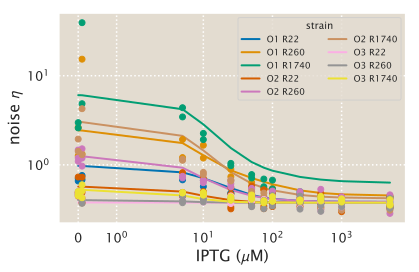

In [134]:
df_group = df_moments.groupby(['operator', 'repressors'])

colors = sns.color_palette('colorblind', n_colors=len(df_group))

for i, (group, data) in enumerate(df_group):
    
    plt.plot(data.inducer_uM, data.p_noise, lw=2,
             color=colors[i],
            label=group[0] + ' R{:.0f}'.format(group[1] * 2))

df_group = df_noise.groupby(['operator', 'repressors'])
    
for i, (group, data) in enumerate(df_group):
    plt.plot(data.IPTG_uM, data.noise, lw=0, marker='o',
             color=colors[i], label='')
#             label=group[0] + ' R{:.0f}'.format(group[1] * 2))
    
# Set scale for axis
plt.xscale('symlog')
plt.yscale('log')

# Label axis
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')

# Set legend
plt.legend(title='strain', ncol=2, fontsize=9)

# Set axis limit
plt.xlim(left=-5E-1)

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'noise_vs_iptg_theory_vs_microscopy.png',
            bbox_inches='tight')

#  Analytical solution of the chemical master equation for the two-state promoter protein distribution

[Shahrezaei and Swain](http://www.pnas.org/content/105/45/17256.short) go into the amazing task of deriving the analytical distribution of the protein copy number for a two-state promoter. To define the distribution let's write the possible reactions that can happen.
\begin{align}
\begin{array}{cc}
\text{reaction} & \text{rate}\\
\text{active} \rightarrow \text{inactive} & k_{off}\\
\text{inactive} \rightarrow \text{active} & k_{on}\\
m \rightarrow m+1 & r_m\\
m \rightarrow m-1 & m \cdot \gamma_m\\
p \rightarrow p+1 & r_p\\
p \rightarrow p-1 & p \cdot \gamma_p\\
\end{array}
\end{align}

Having defined all the possible reactions we can now list a series of definitions that will simplify writing down the distribution.
\begin{align}
a &\equiv \frac{r_m}{\gamma_p}\\
b &\equiv \frac{r_p}{\gamma_m}\\
\gamma &\equiv \frac{\gamma_m}{\gamma_p}\\
K_{on} &\equiv \frac{k_{on}}{\gamma_p}\\
K_{off} &\equiv \frac{k_{off}}{\gamma_p}\\
\end{align}
and
\begin{align}
\alpha &\equiv \frac{1}{2}(a + K_{on} + K_{off} + \phi)\\
\beta &\equiv \frac{1}{2}(a + K_{on} + K_{off} - \phi)\\
\end{align}
 with
 \begin{equation}
\phi ^2 = \left( a + K_{on} + K_{off} \right)^2 - 4 a K_{on}
 \end{equation}

Using all these definitions we can finally write down the steady state distribution of protein $P_{st}(p)$
\begin{align}
P_{st}(p) = &\frac{\Gamma (\alpha + p) \Gamma (\beta + p) \Gamma (K_{on} + K_{off})}{\Gamma (p + 1) \Gamma (\alpha) \Gamma (\beta) \Gamma (K_{on} + K_{off} + p)} \times \\
&\left( \frac{b}{1 + b} \right)^p \left( 1 - \frac{b}{1 + b} \right)^\alpha \times\\
& F^2_1 \left( \alpha + p, K_{on} + K_{off} - \beta, K_{on} + K_{off} + p; \frac{b}{1 + b} \right),
\end{align}
where $F^2_1$ is the [Gauss Hypergeometric function](http://mathworld.wolfram.com/HypergeometricFunction.html).

The mean of this distribution is given by
\begin{equation}
\left\langle p \right\rangle = \frac{\frac{r_m}{\gamma_m}\frac{r_p}{\gamma_p} k_{on}}{k_{on} + k_{off}}.
\end{equation}

# Fitting the $k_{on}$ and $k_{off}$ from experimental data.

As we explained in the mRNA analytical solution when defining the parametres for the equation, if we want to be self consistent between the thermodynamic picture and the chemical master equation framework the **mean** fold-change **at the mRNA level** should satisfy

\begin{equation}
\text{fold-change} = \frac{1}{1 + \frac{k_0 \cdot p_{act} \cdot [R]}{k_{on}}} = \frac{1}{1 + \frac{2R \cdot p_{act}}{N_{NS}} e^{-\beta \Delta \epsilon_r}}
\end{equation}

But actually since the mean protein level is given by

\begin{equation}
\left\langle p \right\rangle = \frac{\frac{r_m}{\gamma_m}\frac{r_p}{\gamma_p} k_{on}}{k_{on} + k_{off}}.
\end{equation}

the terms depending on the production and degradation of protein and mRNA cancel out when computing the fold change and the functional form of the mean fold change ends up being the exact same as for the mRNA level.

This ends up constraining the ratio $k_0 / k_{on}$ such that it is consistent with the energies measured by Hernan as explained before. But there is some doubt about the validity of the $k_0$ value that we quoted from the Elf et. al paper. The main reason is that for the two state model we are explicitly ignoring the empty promter state in order to make analytical progress. That means that the parameter measured by Elf et al. doesn't reflect the reality of this model as it is a rate from the empty to the repressed promoter. What we need for this model is an "effective rate" from the active to the inactive promoter that includes all the processes that happen in between.

An alternative way to obtain these two rates is to use the *single-cell information* that microscopy provides. The difference is that we can not only compute the first moment, but we can make use of the noise in gene expression to obtain these parameters.

In their paper [Shahrezaei and Swain](http://www.pnas.org/content/105/45/17256.short) derive the expression for the noise defined as 

\begin{equation}
\eta \equiv \frac{\sqrt{\left\langle p^2 \right\rangle - \left\langle p \right\rangle^2}}{\left\langle p \right\rangle},
\end{equation}

i.e. the standard deviation over the mean. They claim that the noise should satisfy

\begin{equation}
\eta^2 = \frac{1}{\langle p \rangle} + \frac{\gamma_p}{\gamma_m} \frac{1}{\langle m \rangle} + \frac{\gamma_p}{\gamma_p + k_{on} + k_{off}} \frac{k_{off}}{k_{on}}.
\end{equation}

If we include the assumption that $k_{off} \equiv k_{off}([R])$ and we substitude the definition of mean protein and mean mRNA copy number we find that the noise scales with the number of repressors as

\begin{equation}
\eta^2([R]) = \frac{k_{on} + k_0[R]}{\frac{r_m}{\gamma_m} \frac{r_p}{\gamma_p} k_{on}} + \frac{\gamma_p}{\gamma_m} \frac{k_{on} + k_0[R]}{k_{on} \frac{r_m}{\gamma_m}} + \frac{\gamma_p}{\gamma_p + k_{on} + k_{0}[R]} \frac{k_{0}[R]}{k_{on}}.
\end{equation}

Let's implement a function to compute this noise

In [2]:
def noise_protein(C, rep, ka, ki, epsilon, kon, k0, 
                     gamma_m, r_gamma_m,
                     gamma_p, r_gamma_p):
    '''
    Computes the noise in gene expression as a function of all the parameters
    that go into the chemical master equation.
    
    Parameters
    ----------
    C : array-like.
        Concentration at which evaluate the probability.
    repressor : float.
        repressor copy number per cell.
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    omega : float.
        energetic barrier between the inactive and the active state.
    kon : float.
        rate of activation of the promoter in the chemical master equation
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    gamma_m : float.
        half-life time for the mRNA.
    r_gamma_m : float.
        average number of mRNA in the unregulated promoter.
    gamma_p : float.
        half-life time for the protein.
    r_gamma_p : float.
        average number of protein per mRNA in the unregulated promoter.
    Returns
    -------
    eta the noise in protein distribution
    '''
    # Convert C into np.array
    C = np.array(C)
    # Calculate the off rate including the MWC model
    koff = k0 * rep * chann_cap.p_act(C, ka, ki, epsilon)
    
    # Compute the noise
    mean_m = r_gamma_m * kon / (kon + koff)
    mean_p = r_gamma_m * r_gamma_p * kon / (kon + koff)
    gamma = gamma_m / gamma_p
    return (1 / mean_p + 1 / gamma * 1 / mean_m +\
           gamma_p / (gamma_p + kon + koff) * koff / kon)**(1/2)

Let's compute the noise for different values of $k_0$ changing $k_{off}$ to satisfy the thermodynamic model

In [16]:
# Specify some parameters
k0_array = np.logspace(-8, -2, 200)
repressors = [22, 60, 124, 260, 1220, 1740]
binding_energy = -15.3
prot_params = dict(ka=139, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=10000)

# Compute noise as a function the diffusion limited value and repressor number
noise_array = np.empty([len(k0_array), len(repressors)])
for i, k0 in enumerate(k0_array):
    for j, rep in enumerate(repressors):
    # Repressor copy number of my favorite strain RBS1027
        prot_params['rep'] = rep * 1.66
        prot_params['k0'] = k0
        prot_params['kon'] = chann_cap.kon_fn(binding_energy, k0)
        noise_array[i, j] = noise_protein(0, **prot_params)

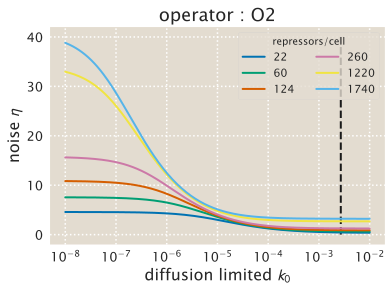

In [18]:
fig = plt.figure()
for j, r in enumerate(repressors):
    plt.plot(k0_array, noise_array[:, j],
            label=str(r))
plt.vlines(2.7E-3, 0, 40, linestyle='--')
plt.xscale('log')
plt.xlabel('diffusion limited $k_0$')
plt.ylabel(r'noise $\eta$')
plt.title('operator : O2')
plt.legend(loc=0, ncol=2, title='repressors/cell')
plt.savefig(figdir + 'noise_vs_diffusion_limited_rate.png',
           bbox_inches='tight')

So indeed this diffusion limited has a clear effect on the noise in gene expression.

### Noise variation as a function of other parameters.

As an interesting exploration let's look at how the noise $\eta$ changes as other parameters such as the mean number of mRNA, proteins or their degradation rates change.

In [5]:
# Specify some parameters
gamma_m_array = np.linspace(3, 10, 50)
repressors = [22, 60, 124, 260, 1220, 1740]
binding_energy = -15.3
prot_params = dict(ka=139, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=10000,
                   k0=2.7E-3)

# Compute noise as a function the diffusion limited value and repressor number
noise_array = np.empty([len(gamma_m_array), len(repressors)])
for i, gamma in enumerate(gamma_m_array):
    for j, rep in enumerate(repressors):
    # Repressor copy number of my favorite strain RBS1027
        prot_params['rep'] = rep * 1.66
        prot_params['kon'] = chann_cap.kon_fn(binding_energy, k0)
        prot_params['gamma_m'] = 1 / (gamma * 60)
        noise_array[i, j] = noise_protein(0, **prot_params)

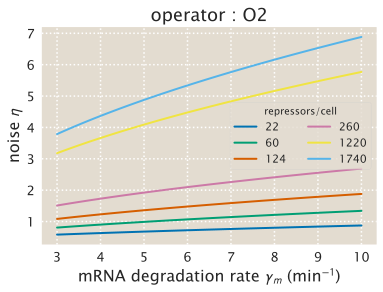

In [6]:
fig = plt.figure()
for j, r in enumerate(repressors):
    plt.plot(gamma_m_array, noise_array[:, j],
            label=str(r))
plt.xlabel('mRNA degradation rate $\gamma_m$ (min$^{-1}$)')
plt.ylabel(r'noise $\eta$')
plt.title('operator : O2')
plt.legend(loc=0, ncol=2, title='repressors/cell')

# Fitting the rates to microscopy data

The idea is to obtain a value for $k_0$ and $k_{on}$ based on the experimental microscopy data.

For this exercise we will use the microscopy data gathered so far.

In [4]:
# Read the tidy-data frame
# mwc_files = glob.glob('../../data/csv_microscopy/mwc_data/*csv')
files = glob.glob('../../data/csv_microscopy/*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)
df_micro[['date', 'operator', 'rbs', 'mean_intensity']].head()

,date,operator,rbs,mean_intensity
0,20161204,O3,auto,52.562979
1,20161204,O3,auto,53.070565
2,20161204,O3,auto,52.323744
3,20161204,O3,auto,51.013142
4,20161204,O3,auto,44.325267


Having read the data let's compute the average noise for the different concentrations. Consider that the noise is defined as
\begin{equation}
\eta \equiv \frac{\sqrt{\left\langle p^2 \right\rangle - \left\langle p \right\rangle^2}}{\left\langle p \right\rangle},
\end{equation}

This means that since the mean protein copy number $\left\langle p \right\rangle$ is involved we need to take into account the **autofluorescence**. So to compute this quantity from the fluroescence measurements we need to compute
\begin{equation}
\eta = \frac{\sqrt{\left\langle (I  - \langle I_{\text{auto}}\rangle)^2 \right\rangle - \left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle^2}}{\left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle},
\end{equation}
where $I$ is the intensity of the objective strain and $\langle I_{\text{auto}}\rangle$ is the mean autofluorescence intensity.

The datasets were taken with a single delta sample and a single autofluorescence sample. So we will compute the noise using the same auto for all IPTG concentrations.

In [9]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Initialize data frame to save the noise
df_noise = pd.DataFrame(columns=['date', 'IPTG_uM','operator', 'binding_energy',
                                 'rbs', 'repressors', 'mean', 'std', 'noise'])
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].mean_intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[(data.rbs != 'auto') & (data.rbs != 'delta')]
    
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Append the require info
        strain_info = [date, inducer, data_inducer.operator.unique()[0],
                       data_inducer.binding_energy.unique()[0],
                       data_inducer.rbs.unique()[0],
                       data_inducer.repressors.unique()[0],
                      (data_inducer.mean_intensity - I_auto).mean(), 
                      (data_inducer.mean_intensity - I_auto).std(ddof=1)]
        # Compute the noise
        strain_info.append(strain_info[-1] / strain_info[-2])
        # Convert to a pandas series to attach to the dataframe
        strain_info = pd.Series(strain_info, index=['date', 'IPTG_uM', 'operator',
                                             'binding_energy',  'rbs', 
                                             'repressors', 'mean', 
                                             'std', 'noise'])
        # Append to the info to the data frame
        df_noise = df_noise.append(strain_info, ignore_index=True)
    
df_noise.head()

,date,IPTG_uM,operator,binding_energy,rbs,repressors,mean,std,noise
0,20161118,0.0,O2,-13.9,RBS1027,130.0,28.660991,34.292514,1.196487
1,20161118,0.1,O2,-13.9,RBS1027,130.0,29.234495,34.792041,1.190102
2,20161118,5.0,O2,-13.9,RBS1027,130.0,71.514148,53.193801,0.743822
3,20161118,10.0,O2,-13.9,RBS1027,130.0,129.849144,87.332807,0.672571
4,20161118,25.0,O2,-13.9,RBS1027,130.0,391.288683,240.143667,0.613725


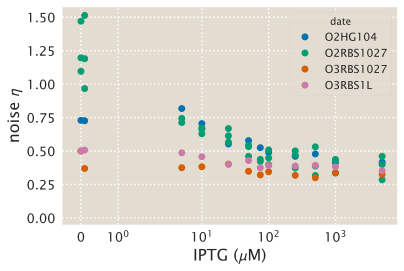

In [9]:
df_group = df_noise.groupby(['operator', 'rbs'])
    
for group, data in df_group:
    plt.plot(data.IPTG_uM, data.noise, lw=0, marker='o',
            label=group[0] + group[1])
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='date')
plt.xlim(left=-5E-1)
plt.ylim(bottom=-0.05)
plt.savefig(figdir + 'microscopy_noise_vs_iptg.png', bbox_inches='tight')
# plt.ylim([-1, 50])
# plt.yscale('log')

# Testing Brewster & Jones parameters

Let's try using the parameters that Brewster and Jones report in their 2014 [paper](http://science.sciencemag.org/content/346/6216/1533.full). For this they used the diffusion limited rate reported by Elf et al. For the repressor dissociation rate they used an *in vitro* measurement done for Oid and then used the ratios of the binding sites equilibrium occupancies compared to Oid in order to determine the values for the other operators.

Let's implement these values

In [19]:
# Define the IPTG concentrations to evaluate the theoretical noise
IPTG = np.logspace(-1, 4, 200)

# Define dictionary containing the kon rates according to Jones & Brewster
kon_dict = {'Oid': 0.0023, 'O1': 0.0069, 'O2': 0.091, 'O3': 2.1}

# Define the CME parameters
prot_params = dict(ka=139.55, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=1000,
                   k0=2.7E-3)

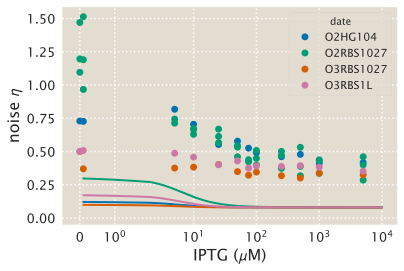

In [20]:
# Group by operator and rbs
df_group = df_noise.groupby(['operator', 'rbs'])

colors = sns.color_palette('colorblind', n_colors=len(df_group))
i = 0
for group, data in df_group:
    # Extract energy and number of repressors
    energy = data.binding_energy.unique()[0]
    repressors = data.repressors.unique()[0]
    # determine kon based on Jones and Brewster 2014
    prot_params['kon'] = kon_dict[data.operator.unique()[0]]
    # Indicate the repressor copy number
    prot_params['rep'] = repressors * 1.66 * 2
    # Compute the theoretical noise for different IPTG concentrations
    noise_thry = noise_protein(C=IPTG, **prot_params)
    # Plot the theoretical noise
    plt.plot(IPTG, noise_thry, color=colors[i])
    # Polot the experimental noise
    plt.plot(data.IPTG_uM, data.noise, lw=0, marker='o',
            label=group[0] + group[1], color=colors[i])
    i+=1
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='date')
plt.xlim(left=-5E-1)
plt.ylim(bottom=-0.05)
plt.savefig(figdir + 'microscopy_noise_vs_iptg_brewster.png', 
            bbox_inches='tight')
# plt.ylim([-1, 5])
# plt.yscale('log')

## Fitting rates to data

Let's find the value of the parameter that satisfies this mean noise level. For this we will use the `scipy.optimize.root` function.

In [21]:
prot_params = dict(ka=139.55, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=1000)

prot_params['gamma_m'] = 1 / (3 * 60)
def root_fn(k0, df, prot_params):
    '''
    function to find the root that satisfies the mean noise level
    '''
    # Extract parameters
    prot_params['k0'] = k0
    
    # Group by date and concentration
    noise_group = df.groupby(['date','IPTG_uM'])
    
    residuals = []
    # Loop through groups returning the residuals
    for group, data in noise_group:
        # Specify parameters for specific data set
        binding_energy = data.binding_energy.unique()[0]
        repressors = data.repressors.unique()[0]
        prot_params['rep'] = 2 * 1.66 * repressors
        prot_params['kon'] = chann_cap.kon_fn(binding_energy, k0)
        
        # Compute experimental noise
        avg_noise = data.noise
        # Append linear residuals
        residuals.append(np.array(noise_protein(group[1], **prot_params) -\
                                  avg_noise))
        # Append the residuals of the log
#         residuals.append(np.array(np.log(noise_protein(group[1], **prot_params))\
#                                    - np.log(avg_noise)))
    return np.array(residuals).ravel()


Text(0,0.5,'$\\chi^2$')

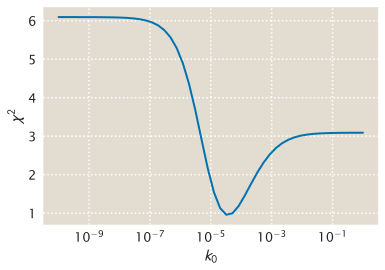

In [22]:
# Let's plot the sum of the square of the residuals as a function of different
# selections of the k0 parameter.
k0_array = np.logspace(-10, 0, 50)
df = df_noise[(df_noise.operator=='O2') & (df_noise.rbs=='HG104')]
plt.plot(k0_array, [np.sum(root_fn(ko, df, prot_params)**2) for ko in k0_array])
plt.xlabel(r'$k_0$')
plt.xscale('log')
plt.ylabel(r'$\chi^2$')

In [23]:
sol = scipy.optimize.least_squares(root_fn, 1E-4, args=(df, prot_params))
k0_fit = sol.x[0]
print('k0 = {:.7f}'.format(k0_fit))

k0 = 0.0000370


/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


###  Testing parameter.

Having obtained a value for the $k_0$ parameter let's see how well it predicts the noise from different strains.

In [24]:
# Define the IPTG concentrations to evaluate the theoretical noise
IPTG = np.logspace(-1, 4, 50)

# Define the CME parameters
prot_params = dict(ka=139.55, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=10,
                   k0=k0_fit)

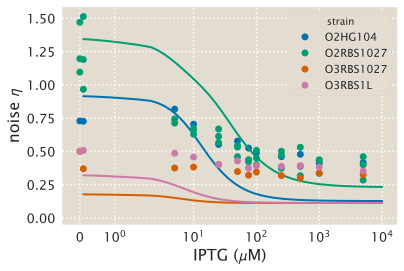

In [26]:
# Group by operator and rbs
df_group = df_noise.groupby(['operator', 'rbs'])

colors = sns.color_palette('colorblind', n_colors=len(df_group))
i = 0
for group, data in df_group:
    # Extract energy and number of repressors
    energy = data.binding_energy.unique()[0]
    repressors = data.repressors.unique()[0]
    # Compute the kon based on Hernan's binding energy and the k0 value
    prot_params['kon'] = chann_cap.kon_fn(epsilon=energy,
                                         k0=prot_params['k0'])
    # Indicate the repressor copy number
    prot_params['rep'] = repressors * 1.66 * 2
    # Compute the theoretical noise for different IPTG concentrations
    noise_thry = noise_protein(C=IPTG, **prot_params)
    # Plot the theoretical noise
    plt.plot(IPTG, noise_thry, color=colors[i])
    # Polot the experimental noise
    plt.plot(data.IPTG_uM, data.noise, lw=0, marker='o',
            label=group[0] + group[1], color=colors[i])
    i+=1
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='strain')
plt.xlim(left=-5E-1)
plt.ylim(bottom=-0.05)
plt.savefig(figdir + 'noise_vs_iptg_fit_ko.png',
           bbox_inches='tight')
# plt.ylim([-1, 5])
# plt.yscale('log')

##  Fitting the parameter to all of the available data.

A different approach to find the best fit parameter is to use all of the available data rather than a single strain. Let's see how different the value would be.

Text(0,0.5,'$\\chi^2$')

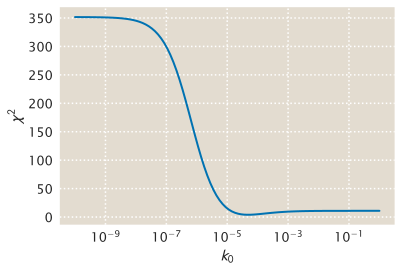

In [15]:
prot_params = dict(ka=139.55, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=1000)

# Let's plot the sum of the square of the residuals as a function of different
# selections of the k0 parameter.
k0_array = np.logspace(-10, 0, 100)
plt.plot(k0_array, [np.sum(root_fn(ko, df_noise, prot_params)**2)\
                    for ko in k0_array])
plt.xlabel(r'$k_0$')
plt.xscale('log')
plt.ylabel(r'$\chi^2$')

In [16]:
sol = scipy.optimize.least_squares(root_fn, 1E-4, args=(df, prot_params))
k0_global_fit = sol.x[0]
print('k0 = {:.7f}'.format(k0_global_fit))

k0 = 0.0000384


/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


In [17]:
# Define the IPTG concentrations to evaluate the theoretical noise
IPTG = np.logspace(-1, 4, 200)

# Define the CME parameters
prot_params = dict(ka=139.55, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=1000,
                   k0=k0_global_fit)

(-0.5, 17398.189457156805)

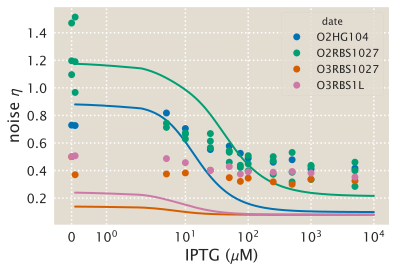

In [18]:
# Group by operator and rbs
df_group = df_noise.groupby(['operator', 'rbs'])

colors = sns.color_palette('colorblind', n_colors=len(df_group))
i = 0
for group, data in df_group:
    # Extract energy and number of repressors
    energy = data.binding_energy.unique()[0]
    repressors = data.repressors.unique()[0]
    # Compute the kon based on Hernan's binding energy and the k0 value
    prot_params['kon'] = chann_cap.kon_fn(epsilon=energy,
                                         k0=prot_params['k0'])
    # Indicate the repressor copy number
    prot_params['rep'] = repressors * 1.66 * 2
    # Compute the theoretical noise for different IPTG concentrations
    noise_thry = noise_protein(C=IPTG, **prot_params)
    # Plot the theoretical noise
    plt.plot(IPTG, noise_thry, color=colors[i])
    # Polot the experimental noise
    plt.plot(data.IPTG_uM, data.noise, lw=0, marker='o',
            label=group[0] + group[1], color=colors[i])
    i+=1
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='date')
plt.xlim(left=-5E-1)
plt.xlim(left=-5E-1)
# plt.ylim([-1, 5])
# plt.yscale('log')

# Empirical subtraction of noise baseline.

Without being able to justify why yet, it seems that there is a baseline on noise for all the samples. If we include this assumption into our model the noise equation is then of the form
\begin{equation}
\eta([R]) = B + \sqrt{ \frac{k_{on} + k_0[R]}{\frac{r_m}{\gamma_m} \frac{r_p}{\gamma_p} k_{on}} + \frac{\gamma_p}{\gamma_m} \frac{k_{on} + k_0[R]}{k_{on} \frac{r_m}{\gamma_m}} + \frac{\gamma_p}{\gamma_p + k_{on} + k_{0}[R]} \frac{k_{0}[R]}{k_{on}}},
\end{equation}
where $B$ represents this base line.

We can then do a two parameter fit to obtain both, the value of $B$ and of $k_o$.

Let's define a function that includes this baseline parameter.

In [21]:
def noise_protein_baseline(C, rep, ka, ki, epsilon, kon, k0,
                           gamma_m, r_gamma_m,
                           gamma_p, r_gamma_p, base):
    '''
    Computes the noise in gene expression as a function of all the parameters
    that go into the chemical master equation.
    
    Parameters
    ----------
    C : array-like.
        Concentration at which evaluate the probability.
    repressor : float.
        repressor copy number per cell.
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    omega : float.
        energetic barrier between the inactive and the active state.
    kon : float.
        rate of activation of the promoter in the chemical master equation
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    gamma_m : float.
        half-life time for the mRNA.
    r_gamma_m : float.
        average number of mRNA in the unregulated promoter.
    gamma_p : float.
        half-life time for the protein.
    r_gamma_p : float.
        average number of protein per mRNA in the unregulated promoter.
    base : float.
        empirical noise baseline added.
    Returns
    -------
    eta the noise in protein distribution
    '''
    # Convert C into np.array
    C = np.array(C)
    # Calculate the off rate including the MWC model
    koff = k0 * rep * chann_cap.p_act(C, ka, ki, epsilon)
    
    # Compute the noise
    mean_m = r_gamma_m * kon / (kon + koff)
    mean_p = r_gamma_m * r_gamma_p * kon / (kon + koff)
    gamma = gamma_m / gamma_p
    return base + (1 / mean_p + 1 / gamma * 1 / mean_m +\
           gamma_p / (gamma_p + kon + koff) * koff / kon)**(1/2)

Let's now define a function to fit both parameters simultaneously

In [22]:
prot_params = dict(ka=139.55, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=1000)

prot_params['gamma_m'] = 1 / (3 * 60)
def root_fn(params, df, prot_params):
    '''
    function to find the root that satisfies the mean noise level
    '''
    # Extract parameters
    prot_params['k0'] = params[0]
    prot_params['base'] = params[1]
    
    # Group by date and concentration
    noise_group = df.groupby(['date','IPTG_uM'])
    
    residuals = []
    # Loop through groups returning the residuals
    for group, data in noise_group:
        # Specify parameters for specific data set
        binding_energy = data.binding_energy.unique()[0]
        repressors = data.repressors.unique()[0]
        prot_params['rep'] = 2 * 1.66 * repressors
        prot_params['kon'] = chann_cap.kon_fn(binding_energy, k0)
        
        # Compute experimental noise
        avg_noise = data.noise
        # Append linear residuals
        residuals.append(np.array(noise_protein_baseline(group[1], **prot_params)\
                                  - avg_noise))
        # Append the residuals of the log
#         residuals.append(np.array(np.log(noise_protein_baseline(group[1], 
#                                                                 **prot_params))\
#                                    - np.log(avg_noise)))
    return np.array(residuals).ravel()


In [23]:
p0 = [1E-4, df_noise.noise.min()]
# df = df_noise[(df_noise.operator != 'O2') | (df_noise.rbs != 'RBS1027')]
# df = df_noise[(df_noise.operator == 'O2') & (df_noise.rbs == 'HG104')]
df = df_noise[df_noise.IPTG_uM > 0]
popt = scipy.optimize.least_squares(root_fn, p0, args=(df, prot_params))
popt.x
k0_global_fit = popt.x[0]
base_global_fit = popt.x[1]
print('k0 = {:.7f}'.format(k0_global_fit))
print('base = {:.2f}'.format(base_global_fit))

k0 = 0.0031881
base = 0.32


(0, 1.5750402571984383)

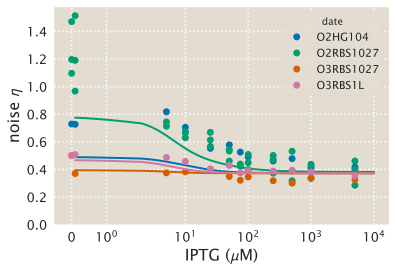

In [24]:
prot_params['k0'] = k0_global_fit
prot_params['base'] = base_global_fit

# Group by operator and rbs
df_group = df_noise.groupby(['operator', 'rbs'])

colors = sns.color_palette('colorblind', n_colors=len(df_group))
i = 0
for group, data in df_group:
    # Extract energy and number of repressors
    energy = data.binding_energy.unique()[0]
    repressors = data.repressors.unique()[0]
    # Compute the kon based on Hernan's binding energy and the k0 value
    prot_params['kon'] = chann_cap.kon_fn(epsilon=energy,
                                         k0=prot_params['k0'])
    # Indicate the repressor copy number
    prot_params['rep'] = repressors * 1.66 * 2
    # Compute the theoretical noise for different IPTG concentrations
    noise_thry = noise_protein_baseline(C=IPTG, **prot_params)
    # Plot the theoretical noise
    plt.plot(IPTG, noise_thry, color=colors[i])
    # Polot the experimental noise
    plt.plot(data.IPTG_uM, data.noise, lw=0, marker='o',
            label=group[0] + group[1], color=colors[i])
    i+=1
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='date')
plt.xlim(left=-5E-1)
plt.ylim(bottom=0)
# plt.ylim([-1, 5])
# plt.yscale('log')

# Subtracting the noise base-line.

Let's look at the noise that comes from the auto-fluorescence data itself. This could give us an indication of what is the baseline noise that we expect to have from the instrument reading.

For this let's look first at the different autofluorescence distributions.



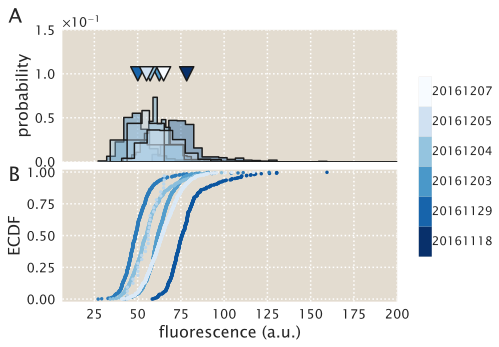

In [25]:
dates = df_micro.date.unique()
colors = sns.color_palette("Blues_r", len(dates))

fig, ax = plt.subplots(2, 1, figsize=(6,5), sharex=True)

# Set the nice scientific notation for the y axis of the histograms
ax[0].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))
ax[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))

# Group data frame by concentration
df_group = df_micro[df_micro.rbs == 'auto'].groupby('date')

# initialize counter for colors
i = 0
mean_fl = []
for c, data in df_group:
    mean_int = data.mean_intensity
    mean_fl.append(mean_int.mean())
    # Histogram plot
    n, bins, patches = ax[0].hist(mean_int, int(np.sqrt(len(mean_int))),
                                normed=1, histtype='stepfilled', alpha=0.4,
                                label=str(c)+ r' $\mu$M', facecolor=colors[i],
                               linewidth=1)
    n, bins, patches = ax[0].hist(mean_int, int(np.sqrt(len(mean_int))),
                                normed=1, histtype='stepfilled', 
                                label='', edgecolor='k',
                               linewidth=1.5, facecolor='none')
    # ECDF Plot
    x, y = chann_cap.ecdf(mean_int)
    ax[1].plot(x, y, '.', label=str(c)+ r' $\mu$M', color=colors[i])
    
    # Increase counter
    i += 1

# # Declare color map for legend
cmap = plt.cm.get_cmap('Blues_r', len(dates))
# bounds = np.linspace(0, len(dates), len(dates) + 1)

# Plot a little triangle indicating the mean of each distribution
mean_plot = ax[0].scatter(mean_fl, [0.1] * len(mean_fl), marker='v', s=200,
            c=np.arange(len(mean_fl)), cmap=cmap,
            edgecolor='k',
            linewidth=1.5)
# # Generate a colorbar with the concentrations
cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])
cbar = fig.colorbar(mean_plot, cax=cbar_ax)
cbar.ax.get_yaxis().set_ticks([])
for j, c in enumerate(dates):
    if c == 0.1:
        c = str(c)
    else:
        c = str(int(c))
    cbar.ax.text(1, j / len(dates) + 1 / (2 * len(dates)),
                 c, ha='left', va='center',
                 transform = cbar_ax.transAxes, fontsize=12)
cbar.ax.get_yaxis().labelpad = 35

ax[0].set_ylim(bottom=0, top=0.15)
ax[0].set_xlim(right=200)
ax[0].set_ylabel('probability')
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
 
ax[1].margins(0.02)
ax[1].set_xlabel('fluorescence (a.u.)')
ax[1].set_ylabel('ECDF')

plt.figtext(0.0, .9, 'A', fontsize=20)
plt.figtext(0.0, .46, 'B', fontsize=20)

plt.subplots_adjust(hspace=0.06)

There is definitely some variability in these measurements. Let's compute the noise defined as
$$
\eta = {\sigma(I_{\text{auto}}) \over \langle I_{\text{auto}} \rangle}
$$

In [26]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Initialize data frame to save the noise
df_noise_auto = pd.DataFrame(columns=['date', 'operator', 'binding_energy',
                                 'mean', 'std', 'noise'])
for date, data in df_group:
    # Extract the strain fluorescence measurements
    strain_data = data[data.rbs == 'auto']
    
    # Append the require info
    strain_info = [date, data.operator.unique()[0],
                   data.binding_energy.unique()[0],
                   data.mean_intensity.mean(), 
                   data.mean_intensity.std(ddof=1)]
    # Compute the noise
    strain_info.append(strain_info[-1] / strain_info[-2])
    # Convert to a pandas series to attach to the dataframe
    strain_info = pd.Series(strain_info, index=['date', 'operator',
                                         'binding_energy',
                                         'mean', 'std', 'noise'])
        # Append to the info to the data frame
    df_noise_auto = df_noise_auto.append(strain_info, ignore_index=True)
    
df_noise_auto.head()

,date,operator,binding_energy,mean,std,noise
0,20161118,O2,-13.9,678.793880,705.662572,1.039583
1,20161129,O2,-13.9,852.431326,940.884982,1.103766
2,20161203,O2,-13.9,1743.797600,1688.090044,0.968054
3,20161204,O3,-9.7,5094.517520,2588.718981,0.508138
4,20161205,O3,-9.7,3200.939684,1842.300834,0.575550


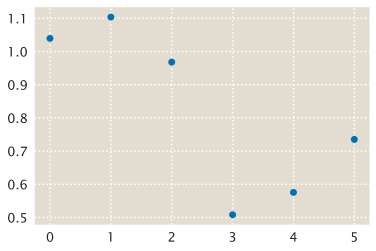

In [27]:
plt.plot(df_noise_auto.noise, marker='o', lw=0)

# Inferring $r_p$ from unregulated promoter data.

An interesting insight from the theory can be derived by considering the solution for a one-state (unregulated) promoter protein distribution.

Shahrezaei & Swain derived the solution for an unregulated promoter. This is given by
$$
P_{unreg}(p) = {\Gamma\left( {r_m \over \gamma_p} + p \right) \over
                \Gamma (p + 1)\Gamma\left( {r_m \over \gamma_p} \right)}
                \left( {{r_p \over \gamma_m} \over 1 + {r_p \over \gamma_m}}\right)^p
                \left( 1 - 
                {{r_p \over \gamma_m} \over 1 + {r_p \over \gamma_m}} \right)
                ^{r_m \over \gamma_p},
$$
which is a negative binomial distribution. The negative binomial has a variance of the form
$$
\text{Var}(p) = {{{r_p \over \gamma_m} \over 1 + {r_p \over \gamma_m}} \over
                 \left( 1 - {{r_p \over \gamma_m} \over 
                 1 + {r_p \over \gamma_m}} \right)^2} \cdot
                 {r_m \over \gamma_p}.
$$
When simplified this equation gives
\begin{align}
\text{Var}(p) &= {r_p \over \gamma_m}{r_m \over \gamma_p}
                 \left( 1 + {r_p \over \gamma_m} \right)\\
              &= \left\langle p \right\rangle_{unreg}
                 \left( 1 + {r_p \over \gamma_m} \right)\\
\end{align}

Using this expression for the variance we have that the noise $\eta$ must satisfy
\begin{align}
\eta_{unreg}^2 &= {1 \over \left\langle p \right\rangle_{unreg}}
                 \left( 1 + {r_p \over \gamma_m} \right), \\
               &= {\gamma_m \gamma_p \over r_m r_p}
                 \left( 1 + {r_p \over \gamma_m} \right).
\end{align}

Solving for $r_p$ we have
$$
r_p = {\gamma_m \gamma_p \over r_m} \left( \eta_{unreg}^2 - 
                                         {\gamma_p \over r_m} \right)^{-1}
$$

This result implies that we can use the $\Delta lacI$ expression data to obtain the value of the parameter $r_p$ assuming we know the value of $\gamma_m$, $r_m$ and $\gamma_p$ as reported from the literature.

Let's first compute the mean and variance of the delta strains.

In [27]:
files = glob.glob('../../data/csv_microscopy/*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)
df_micro[['date', 'operator', 'rbs', 'mean_intensity']].head()

,date,operator,rbs,mean_intensity
0,20161204,O3,auto,52.562979
1,20161204,O3,auto,53.070565
2,20161204,O3,auto,52.323744
3,20161204,O3,auto,51.013142
4,20161204,O3,auto,44.325267


In [28]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Initialize data frame to save the noise
df_delta_noise = pd.DataFrame(columns=['date', 'operator', 'binding_energy',
                                      'mean_intensity', 'variance', 'noise_square'])
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].mean_intensity.mean()
    
    # Extract the strain fluorescence measurements
    delta_data = data[data.rbs == 'delta']
    
    # Append the require info
    delta_info = [date, delta_data.operator.unique()[0],
                   delta_data.binding_energy.unique()[0],
                  (delta_data.mean_intensity - I_auto).mean(), 
                  (delta_data.mean_intensity - I_auto).var(ddof=0)]
    # Compute the noise
    delta_info.append(delta_info[-1] / delta_info[-2]**2)
    # Convert to a pandas series to attach to the dataframe
    delta_info = pd.Series(delta_info, index=['date', 'operator', 
                                                'binding_energy', 'mean_intensity',
                                                'variance', 'noise_square'])
    # Append to the info to the data frame
    df_delta_noise = df_delta_noise.append(delta_info, ignore_index=True)
    
df_delta_noise

,date,operator,binding_energy,mean_intensity,variance,noise_square
0,20161118,O2,-13.9,2300.650565,7.868868e+05,0.148666
1,20161129,O2,-13.9,2402.292147,2.216911e+06,0.384146
2,20161203,O2,-13.9,4772.751592,2.436598e+06,0.106966
3,20161204,O3,-9.7,5426.807369,4.354018e+06,0.147843
4,20161205,O3,-9.7,3495.582203,2.070428e+06,0.169442
5,20161207,O2,-13.9,2592.440501,1.528578e+06,0.227442


Now let's define a simple function to give the value of $r_p$ given the value of the experimental noise and $\gamma_m$, $\gamma_p$ and $r_m$.

In [29]:
def rp_noise(noise_square, gamma_m=0.00284, r_gamma_m=15.7, gamma_p=0.000277):
    '''
    Computes the protein production rate r_p for a given unregulated promoter
    given the experimental noise squared (var / mean**2) and the production rate
    of mRNA as well as the degradation rates of protein and mRNA
    Parameters
    ----------
    noise_square : array-like.
        Experimental fluorescence variance / mean**2
    gamma_m : float
        mRNA degradation rate (time**-1)
    r_gamma_m : float.
        mean number of mRNA for an unregulated promoter
    gamma_p : float.
        degradation rate protein (time**-1). NOTE: Time units should be the same
        as gamma_m
    Returns
    -------
    rp : array-like.
        protein production rate
    '''
    # Obtain the mRNA production rate from the degradation rate and the mean
    # mRNA copy number
    r_m = r_gamma_m * gamma_m
    return (gamma_m * gamma_p) / r_m * (noise_square - gamma_p / r_m)**-1

In [33]:
gamma_p = 0.000277
df_delta_noise['r_p'] = rp_noise(df_delta_noise.noise_square.values)
df_delta_noise['r_gamma_p'] = rp_noise(df_delta_noise.noise_square.values) /\
                              gamma_p
df_delta_noise.round(5)

,date,operator,binding_energy,mean_intensity,variance,noise_square,r_p,r_gamma_p
0,20161118,O2,-13.9,2300.65057,7.868868e+05,0.14867,0.00012,0.44712
1,20161129,O2,-13.9,2402.29215,2.216911e+06,0.38415,0.00005,0.16853
2,20161203,O2,-13.9,4772.75159,2.436598e+06,0.10697,0.00018,0.63218
3,20161204,O3,-9.7,5426.80737,4.354018e+06,0.14784,0.00012,0.44972
4,20161205,O3,-9.7,3495.58220,2.070428e+06,0.16944,0.00011,0.39021
5,20161207,O2,-13.9,2592.44050,1.528578e+06,0.22744,0.00008,0.28791
